<a href="https://colab.research.google.com/github/brownr16/electromagnetics_modelling/blob/main/HarmonicCircuitAnalysis_MultiPoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Steady-State Time-Domain Waveforms Using Harmonic Circuit Analysis </h1></b>

Dr. Bingsen Wang

5/7/2023
</center>

#Introduction

For analysis of power electronic systems, it is often of the interest to assess the time-domain waveforms of various quantities. One tool that is commonly resorted to is time-domain simulations, which essentially integrate the differential equations representing the system dynamics over small time steps. The simulation tools are available in the forms of commercial ones and open-source ones.

Although the time-domain simulations are widely utilized, they could be computational expensive in particular when multiple operating points are simulated.

If the steady-state instead of transient waveforms are of primary interest, the harmonic circuit analysis can be employed as an alternative to the time-domain numerical simulation.

#Harmonic Circuit Analysis

Central to the method of harmonic circuit analysis is to transform time-domain excitation variable into the frequency domain using fast Fourier transform (FFT). Then, the solution to the response variable is obtained in frequency domain using algebraic equations instead of differential equations. The final step is to convert the solution into time domain using the inverse Fourier transform (IFFT).

#Python Code
The Python code illustrates using harmonic circuit analysis process determine the waveforms at multiple operating points for an RL load fed by square-wave source.

<ipython-input-18-8abf79b57115>:177: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
<ipython-input-18-8abf79b57115>:124: MatplotlibDeprecationWarning: Passing the width parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(mp.Arrow(0 - 0.5*iL,2,


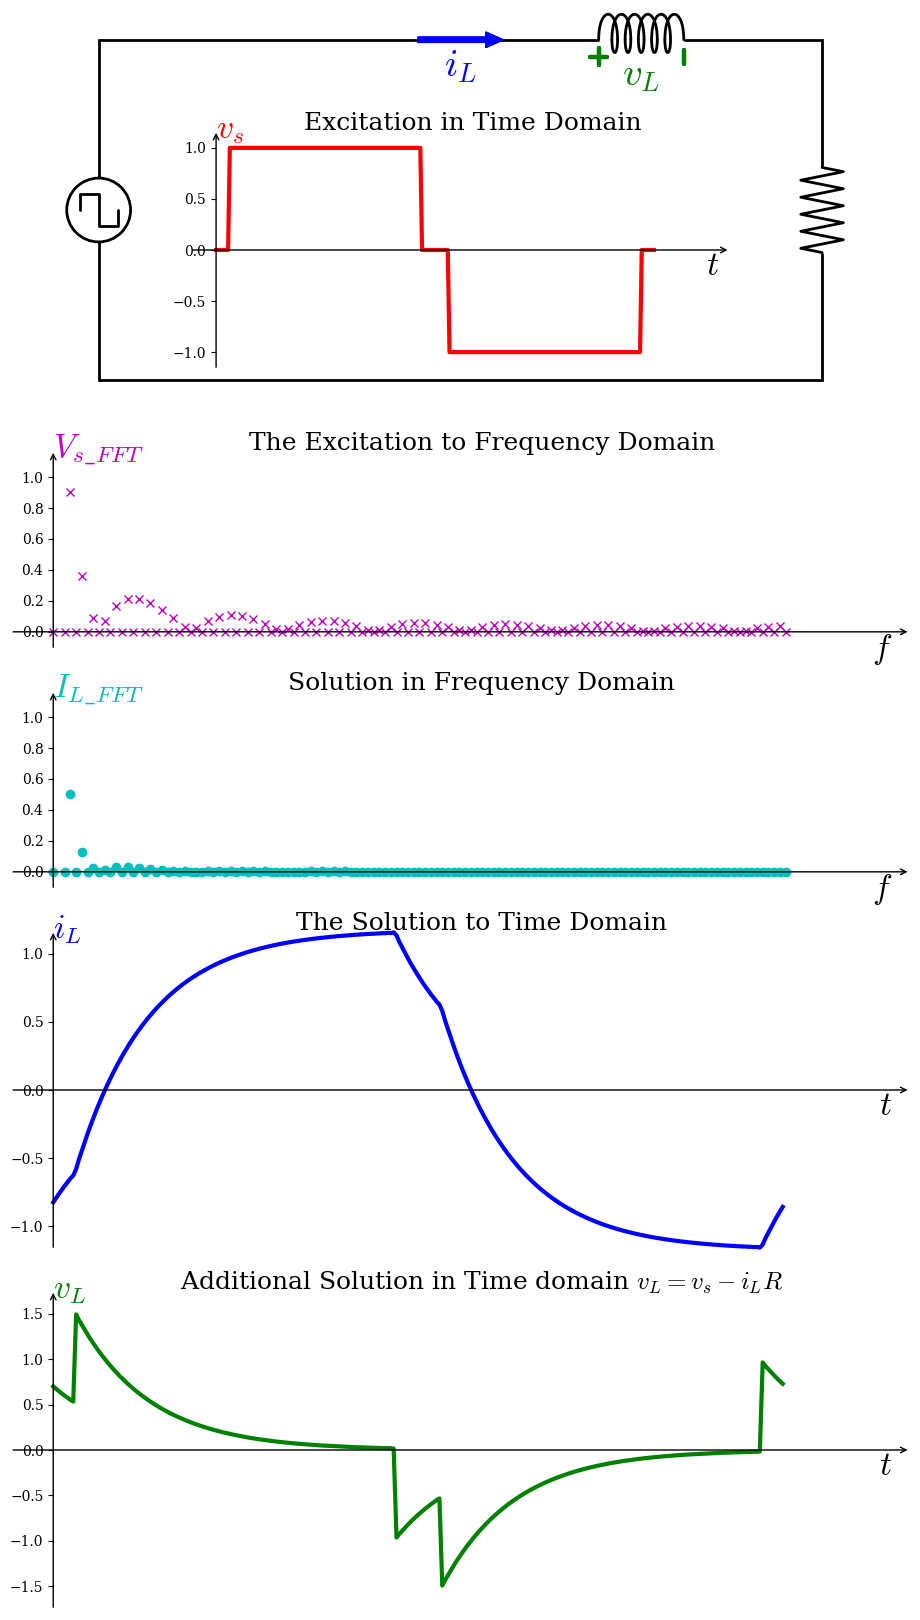

In [ ]:
import numpy as np
from numpy import linspace,sin,cos,pi,heaviside,fft,abs
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.path import Path
import matplotlib.patches as mp
from matplotlib.collections import PatchCollection
from matplotlib import animation,rc,transforms
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#source voltage
def vs(t,f,alpha1,alpha2):
  """
  f: frequency in Hz
  alpha1,alph2: pulse angles, 0-pi/2
  """
  v=sin(2*pi*f*t)
  pulse1 = heaviside(abs(v)-sin(alpha1),0)*(2*heaviside(v,0)-1)
  pulse2 = heaviside(abs(v)-sin(alpha2),0)*(2*heaviside(v,0)-1)
  return pulse1-pulse2

#draw inductor symbol
def drawInductor(ax,x0,y0,n,h,theta,lw,color):
  """
  n: number of coils
  h: height or width
  theta: orientation 0 for horizontal 90 for vertical
  lw: line weight
  """
  w= h/(0.7*n+0.3)#width of larger coil
  plg=[] #the half coil with larger curvature
  psm=[] #the half coil with smaller curvature
  for k in range(n):
    if k==0:
      p = mp.PathPatch(Path([(x0,y0),(x0,y0+0.4*h),(x0+w,y0+0.4*h),(x0+w,y0)],
                            [Path.MOVETO,Path.CURVE4,Path.CURVE4,Path.CURVE4]))
      plg.append(p)
    else:
      p = mp.PathPatch(Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0+0.4*h),(x0+(0.7*k+1)*w,y0+0.4*h),(x0+(0.7*k+1)*w,y0)],
                            [Path.MOVETO,Path.CURVE4,Path.CURVE4,Path.CURVE4]))
      plg.append(p)
      p = mp.PathPatch(Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0-0.2*h),(x0+(0.7*k+0.3)*w,y0-0.2*h),(x0+(0.7*k+0.3)*w,y0)],
                            [Path.MOVETO,Path.CURVE4,Path.CURVE4,Path.CURVE4]))
      psm.append(p)
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(np.concatenate((plg,psm)),ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw resistor symbol
def drawResistor(ax,x0,y0,n,h,theta,lw,color):
  """
  n: number of zig-zags
  h: height or width
  theta: orientation 0 for horizontal 90 for vertical
  lw: line weight
  """
  w= h/n#width of larger coil
  plg=[] #the half coil with larger curvature
  psm=[] #the half coil with smaller curvature
  for k in range(n):
    p = mp.PathPatch(Path([(x0 + k*w,y0),(x0 + (k+0.25)*w,y0+0.25*h),(x0+(0.75+k)*w,y0-0.25*h),(x0+(k+1)*w,y0)],
                          [Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO]))
    plg.append(p)
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(np.concatenate((plg,psm)),ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw voltage source square symbol
def drawVoltSourceSqaure(ax,x0,y0,h,theta,lw,color):
  """
  x0,y0: center of the votlage circle
  h: height or width
  theta: orientation 0 for horizontal 90 for vertical
  lw: line weight
  """
  p_cirle = mp.Circle((x0,y0),h*.5)
  p_square = mp.PathPatch(Path([(x0-.3*h,y0),(x0-.3*h,y0+.25*h),(x0,y0+.25*h),
                                (x0,y0-.25*h),(x0+.3*h,y0-.25*h),(x0+.3*h,y0)],
                               [Path.MOVETO,Path.LINETO,Path.LINETO,
                                Path.LINETO,Path.LINETO,Path.LINETO]))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection([p_cirle,p_square],
                     ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw the +/- voltage polarity with variable distance/color
def drawVoltSign(ax,x0,y0,h,theta,lw,color):
  """
  x0,y0: center between "+" and "-"
  h: height or width
  theta: orientation 0 for horizontal 90 for vertical
  lw: line weight
  """
  p = Path([(x0-0.5*h,y0-0.1*h),(x0-0.5*h,y0+0.1*h),(x0-0.6*h,y0),(x0-0.4*h,y0),
            (x0+0.5*h, y0-0.08*h),(x0+0.5*h, y0+0.08*h)],
           [Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO,
            Path.MOVETO,Path.LINETO])
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  ax.add_patch(mp.PathPatch(p,ec=color,fc='none',lw=lw,transform=rot,capstyle='round'))
  return

#draw the Non-Animated part of the cirucit
def drawCircuitNA(ax,lw,clst):
  pth = Path([(-4.25,0.375),(-4.25,2),(1.625,2),
              (2.625,2),(4.25,2),(4.25,0.5),
              (4.25,-0.5),(4.25,-2),(-4.25,-2),(-4.25,-0.375)],
             [Path.MOVETO,Path.LINETO,Path.LINETO,
              Path.MOVETO,Path.LINETO,Path.LINETO,
              Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO])
  ax.add_patch(mp.PathPatch(pth,fc='none',lw=lw))
  drawVoltSourceSqaure(ax,-4.25,0,0.75,0,lw,'k')
  drawInductor(ax,1.625,2,6,1,0,lw,'k')
  drawResistor(ax,4.25,0.5,5,1,-90,lw,'k')
  ax.text(0,1.9,r'$i_L$',size=28,color=clst[3],ha='center',va='top')
  ax.text(2.125,1.8,r'$v_L$',size=28,color=clst[4],ha='center',va='top')
  return

# animated part of the diagram
def drawCircuitAnim(ax,iL,vL,clst):
  ax.add_patch(mp.Arrow(0 - 0.5*iL,2,
                        iL,0,0.3,color=clst[0])) #load current
  drawVoltSign(ax,2.125,1.8,vL,0,3,clst[1])
  return


#parameters
f=1
Z=1
pf=0.85 #lagging
R=Z*pf
L=Z*np.sqrt(1-pf**2)/(2*pi*f)
Nfpp = 100
Nf = Nfpp*1
t=linspace(0,1/f,256)
alpha1 = pi/16
alpha2 = linspace(pi/2,alpha1,Nfpp)


#set up the figures
fig = plt.figure(figsize=(9,16))
km = 1.175 # margin
ax_frame = [[(0,.75 , 1, .25),[-4.5*km,4.5*km],[-2*km,2*km]], #circuit diagram
            [(0,.75 , 1, .25),[-4.5*km,4.5*km],[-2*km,2*km]], #animated circuit
            [(.2,.775, .6, .15),[-.05*km,1*km],[-1*km,1*km]], # vs
            [(0,.6 , 1, .125),[-.05*km,1*km],[-.1*km,1*km]], #V_s_FFT
            [(0,.45 , 1, .125),[-.05*km,1*km],[-.1*km,1*km]], #I_L_FFT
            [(0,.225 , 1, .2),[-.05*km,1*km],[-1*km,1*km]], #i_L
            [(0,0 , 1, .2),[-.05*km,1*km],[-1.5*km,1.5*km]] #v_L        
            ]# [pos-boundary, xlim, ylim]
ax_lst=[] #axis list
ax_lbl=[[r'$v_s$',r'$t$'],[r'$V_{s\_FFT}$',r'$f$'],
        [r'$I_{L\_FFT}$',r'$f$'],[r'$i_L$',r'$t$'],[r'$v_L$',r'$t$']]
clst=['r','m','c','b','g']
text_tls = [] #place holder for titles of each plot updated during animation
for k in range(len(ax_frame)):
  ax=fig.add_axes(ax_frame[k][0],xlim=ax_frame[k][1], ylim=ax_frame[k][2],
                  fc='none') #remove frame face color
  if k<2:
    ax.axis('off') #turn the first 2 axes for circuit digram completely off
  else: #the rest axes
    ax.spines[:].set_visible(False) #set all spines off
    ax.spines['left'].set_position(('data', 0)) #set spines to cross zero
    ax.set_xticks([]) #set x-axis ticks off
    xmin,xmax,ymin,ymax=np.concatenate((ax_frame[k][1],ax_frame[k][2]))
    ax.annotate("", xy=(xmax, 0), xytext=(xmin, 0),
          arrowprops=dict(arrowstyle="->")) #draw x-axis with arrow
    ax.annotate("", xy=(0,ymax), xytext=(0,ymin),
          arrowprops=dict(arrowstyle="->")) #draw x-axis with arrow
    ax.text(0,ymax,ax_lbl[k-2][0],size=24,va='center',color=clst[k-2])
    ax.text(xmax-0.025,0,ax_lbl[k-2][1],size=24,va='top',ha='right',color='k')
    text_tls.append(ax.text(xmax*.5,ymax,'',size=18,ha='center'))
  ax_lst.append(ax)
fig.tight_layout()


lines = [] #array containing all the line segments
for k in range(5):
  if k==1:
    lines.append(ax_lst[k+2].plot([],[],color=clst[k],ls='none', marker='x')[0])
  elif k==2:
    lines.append(ax_lst[k+2].plot([],[],color=clst[k],ls='none', marker='o')[0])
  else:
    lines.append(ax_lst[k+2].plot([],[],color=clst[k],lw=3)[0])

# animation function. This is called sequentially
def animate(i):
  vst = vs(t,f,alpha1,alpha2[i])
  Vs_fft = fft.rfft(vst) #step #1
  IL_fft=[] #step #2
  for n in range(np.shape(Vs_fft)[-1]):
    IL_fft.append(Vs_fft[n]/(R + 1j*(2*pi*f)*n*L)) # each harmonic current phasor
  iLt = fft.irfft(IL_fft) #step #3
  vLt = vst-iLt*R # find additional solution in time domain 
  if i==0:
    drawCircuitAnim(ax_lst[1],1,1,clst[-2:])
    text_tls[0].set_text('Excitation in Time Domain')
    text_tls[1].set_text('The Excitation to Frequency Domain')
    text_tls[2].set_text('Solution in Frequency Domain')
    text_tls[3].set_text('The Solution to Time Domain')
    text_tls[4].set_text(r'Additional Solution in Time domain $v_L = v_s - i_LR$')
  lines[0].set_data(t,vst)
  lines[1].set_data(t[0:int(256*0.5)+1]*2,abs(Vs_fft)/Nfpp*2)
  lines[2].set_data(t[0:int(256*0.5)+1]*2,abs(IL_fft)/Nfpp*2)
  lines[3].set_data(t,iLt)
  lines[4].set_data(t,vLt)
  return

drawCircuitNA(ax_lst[0],2,clst)
anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following three lines
fn = r"harmonicCircuitAnalysis_multi.mp4" 
writervideo = animation.FFMpegWriter(fps=5) 
anim.save(fn, writer=writervideo,dpi = 120)

#debug
# ax_lst[3].plot(t[0:int(Nfpp*0.5)+1]*2,abs(Vs_fft)/Nfpp*2,color=clst[1], ls='none', marker='x')
# ax_lst[3].clear()
# ax_lst[4].stem(t[0:int(Nfpp*0.5)+1]*2,abs(IL_fft)/Nfpp*2,linefmt=clst[2], markerfmt='x')
# ax_lst[5].plot(t,iLt,color=clst[5-2])
# ax_lst[6].plot(t,vLt,color=clst[6-2])
# drawVSIanim(ax1,mht[:][1],iact[:][1],iht[:][1],idct[1])
# ax_lst[0].axis('on')
# drawCircuitNA(ax_lst[0],2)
# drawVoltSourceSqaure(ax,0,0,1,0,2,'k')
# print(4/pi*(cos(alpha1)-cos(alpha2)))